In [2]:
%load_ext autoreload
%autoreload 2

import pathlib
if pathlib.Path().resolve().name == 'notebooks':
    %cd ..
%pwd

import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from src.data import NHLDataDownloader
from src.features import load_df_shots, add_goalie_ratio, add_opponent_concedes, add_shooter_ratio, add_team_goals

/Users/alexandreganito/Documents/Data science/Project/NHL


In [2]:
nhl = NHLDataDownloader(2016)
test = nhl.load_processed_data()

Season 2016 successfully loaded from file
Processing data... (1-2 minutes)
Done!


In [5]:
columns = ['Shot_distance', 'Shot_angle', 'Goal', 'Empty_net']
df_2016 = load_df_shots(2016)
df_2017 = load_df_shots(2017)
df_2018 = load_df_shots(2018)
df_2019 = load_df_shots(2019)
df_2020 = load_df_shots(2020)

# df_tot = pd.concat([df_2016, df_2017, df_2018, df_2019]).reset_index(drop=True)
df = pd.concat([df_2016, df_2017, df_2018, df_2019, df_2020]).reset_index(drop=True)
# df = df_tot[columns]

In [4]:
df = add_shooter_ratio(df)
df = add_goalie_ratio(df)
df = add_team_goals(df)
df = add_opponent_concedes(df)

In [5]:
df.drop('Strength', axis=1, inplace=True)
df.Shot_angle = df.Shot_angle.abs()
df.to_pickle("final.pkl")

In [83]:
dfp = df

In [342]:
from src.client import start_experiment

In [349]:
exp = start_experiment()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, tensorboard, keras, sklearn, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dizga/test/fca2ee2765014c2bbf49fe8885b75617



In [351]:
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dizga/test/fca2ee2765014c2bbf49fe8885b75617
COMET INFO:   Uploads:
COMET INFO:     dataframe                : 1 (17.48 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.25 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, tensorboard, keras, sklearn, tensorflow.
COMET INFO: Please wait fo

In [346]:
subset_df = df[(df.Year == 2017) & (df.Game_id == 1065)]

In [350]:
exp.log_dataframe_profile(subset_df, name='wpg_v_wsh_2017021065', dataframe_format='csv')

COMET WARNING: pandas_profiling is required to log profile; ignoring


{'profile': None,
 'dataframe': {'web': 'https://www.comet.com/api/asset/download?assetId=1a115b61bde44f62bf6320a5add8ba95&experimentKey=fca2ee2765014c2bbf49fe8885b75617',
  'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=1a115b61bde44f62bf6320a5add8ba95&experimentKey=fca2ee2765014c2bbf49fe8885b75617',
  'assetId': '1a115b61bde44f62bf6320a5add8ba95'}}

In [57]:
goal_df = df_all[['Year','Game_id','Shooter', 'Goal']]
goal_ratio_df = goal_df.groupby(['Year','Game_id', 'Shooter']).Goal.mean().reset_index(name='Goal_ratio')

base = pd.DataFrame([[0,0,n,0.1] for n in goal_ratio_df.Shooter.unique()], columns=goal_ratio_df.columns)
goal_ratio_df = pd.concat([base, goal_ratio_df]).reset_index(drop=True)
goal_ratio_df['Ema'] = goal_ratio_df.groupby('Shooter')['Goal_ratio'].transform(
    lambda x: x.ewm(alpha=0.01, adjust=False).mean()
)

df_all = df_all.drop('Shooter_ratio', axis=1, errors='ignore')

goal_ratio_df['Shooter_ratio'] = goal_ratio_df.groupby('Shooter')['Ema'].shift().round(4)
df_all = df_all.merge(goal_ratio_df[['Year','Game_id', 'Shooter', 'Shooter_ratio']], how='left', on=['Year','Game_id', 'Shooter'])

In [58]:
save_df = df_all[['Year','Game_id','Goalie', 'Goal']]
save_ratio_df = save_df.groupby(['Year','Game_id', 'Goalie']).Goal.mean().reset_index(name='Save_ratio')
save_ratio_df.Save_ratio = 1 - save_ratio_df.Save_ratio

base = pd.DataFrame([[0,0,n,0.9] for n in save_ratio_df.Goalie.unique()], columns=save_ratio_df.columns)
save_ratio_df = pd.concat([base, save_ratio_df]).reset_index(drop=True)
save_ratio_df['Ema'] = save_ratio_df.groupby('Goalie')['Save_ratio'].transform(
    lambda x: x.ewm(alpha=0.01, adjust=False).mean()
)

df_all = df_all.drop('Goalie_ratio', axis=1, errors='ignore')

save_ratio_df['Goalie_ratio'] = save_ratio_df.groupby('Goalie')['Ema'].shift().round(4)
df_all = df_all.merge(save_ratio_df[['Year','Game_id', 'Goalie', 'Goalie_ratio']], how='left', on=['Year','Game_id', 'Goalie'])
df_all.loc[df_all.Goalie == '', 'Goalie_ratio'] = 0.5

In [59]:
goal_df = df_all[['Year','Game_id','Team', 'Goal']]
goal_ratio_df = goal_df.groupby(['Year','Game_id', 'Team']).apply(
    lambda x: x['Goal'].sum()
).reset_index(name='Goal_ratio')

base = pd.DataFrame([[0,0,n,3] for n in goal_ratio_df.Team.unique()], columns=goal_ratio_df.columns)
goal_ratio_df = pd.concat([base, goal_ratio_df]).reset_index(drop=True)
goal_ratio_df['Ema'] = goal_ratio_df.groupby('Team')['Goal_ratio'].transform(
    lambda x: x.ewm(alpha=0.01, adjust=False).mean()
)

df_all = df_all.drop('Team_goals', axis=1, errors='ignore')

goal_ratio_df['Team_goals'] = goal_ratio_df.groupby('Team')['Ema'].shift().round(4)
df_all = df_all.merge(goal_ratio_df[['Year','Game_id', 'Team', 'Team_goals']], how='left', on=['Year','Game_id', 'Team'])

In [60]:
goal_df = df_all[['Year','Game_id', 'OppTeam', 'Goal']]
goal_ratio_df = goal_df.groupby(['Year','Game_id', 'OppTeam']).apply(
    lambda x: x['Goal'].sum()
).reset_index(name='Goals')

base = pd.DataFrame([[0,0,n,3] for n in goal_ratio_df.OppTeam.unique()], columns=goal_ratio_df.columns)
goal_ratio_df = pd.concat([base, goal_ratio_df]).reset_index(drop=True)
goal_ratio_df['Ema'] = goal_ratio_df.groupby('OppTeam')['Goals'].transform(
    lambda x: x.ewm(alpha=0.01, adjust=False).mean()
)

df_all = df_all.drop('Opp_concedes', axis=1, errors='ignore')

goal_ratio_df['Opp_concedes'] = goal_ratio_df.groupby('OppTeam')['Ema'].shift().round(4)
df_all = df_all.merge(goal_ratio_df[['Year','Game_id', 'OppTeam', 'Opp_concedes']], how='left', on=['Year','Game_id', 'OppTeam'])

In [4]:
import plotly.express as px


ddd = pd.DataFrame([["1 / 500 / 4 ", 0.777], ["1.5 / 400 / 4 ", 0.781], ["2 / 200 / 5 ", 0.78], ["3 / 300 / 6 ", 0.776]],
                   columns=['hypers', 'AUC'])


# ddd
fig = px.histogram(ddd, x='AUC', y='hypers', labels=dict(hypers="Pos Weight / Estimators / Max depth"), histfunc='avg')

# px.scatter_3d(x=[3,1,1.5], y=[300,500,400], z=[0.777,0.776,0.781], color=[1,2,3],
#               labels=dict(x="Pos Weight", y="Estimators", z="AUC", color='accuracy'))

# import plotly.express as px
# fig = px.scatter_3d(x=[3,1,1.5], y=[300,500,400], z=[0.777,0.776,0.781], color=[1,2,3])
fig.update_xaxes(range=[0.76, 0.79])
fig.show()
fig.write_html(f'../NHL-blog/_includes/hp-tuning.html')

In [8]:
df_tot = df[[
        'Game_id',
        'Game_time',
        'Type',
        # 'Empty_net',
        'Previous_distance',
        # 'X_diff',
        'Speed',
        # 'Period',
        # 'Is_rebound',
        'Time_since_powp',
        'Players',
        'Opp_players',
        'P_diff',
        'Shot_distance',
        # 'X_net',
        'Shot_angle',
        'Rebound_angle',
        'Year',
        'Shooter_ratio',
        'Goalie_ratio',
        'Team_goals',
        'Opp_concedes',
        'Previous_event_type',
        'Goal']].copy()

In [32]:
df_2016 = load_df_shots(2016)
df_2017 = load_df_shots(2017)
df_2018 = load_df_shots(2018)
df_2019 = load_df_shots(2019)
df_2020 = load_df_shots(2020)

df = pd.concat([df_2016, df_2017, df_2018, df_2019, df_2020]).reset_index(drop=True)

df = add_shooter_ratio(df)
df = add_goalie_ratio(df)
df = add_team_goals(df)
df = add_opponent_concedes(df)

df.Shot_angle = df.Shot_angle.abs()
df['Powp'] = df.Players - df.Opp_players
df.loc[df.Powp < 0, 'Powp'] = 0
df

,Game_id,Game_time,Period,Time,Team,OppTeam,Goal,X,Y,Shooter,...,X_net,Shot_distance,Shot_angle,Rebound_angle,Year,Shooter_ratio,Goalie_ratio,Team_goals,Opp_concedes,Powp
0,1,71,1,01:11,TOR,OTT,False,-77.0,5.0,Mitchell Marner,...,12.0,13.000000,22.619865,0.0,2016,0.1000,0.9000,3.0000,3.0000,0
1,1,173,1,02:53,OTT,TOR,False,86.0,13.0,Chris Kelly,...,3.0,13.341664,77.005383,0.0,2016,0.1000,0.9000,3.0000,3.0000,0
2,1,241,1,04:01,OTT,TOR,False,23.0,-38.0,Cody Ceci,...,66.0,76.157731,29.931512,0.0,2016,0.1000,0.9000,3.0000,3.0000,0
3,1,286,1,04:46,OTT,TOR,False,33.0,-15.0,Erik Karlsson,...,56.0,57.974132,14.995079,0.0,2016,0.1000,0.9000,3.0000,3.0000,0
4,1,406,1,06:46,TOR,OTT,False,-34.0,28.0,Martin Marincin,...,55.0,61.717096,26.980231,0.0,2016,0.1000,0.9000,3.0000,3.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358203,868,3597,3,19:57,SJS,ARI,False,71.0,-16.0,Noah Gregor,...,18.0,24.083189,41.633539,0.0,2020,0.1053,0.9032,2.8750,2.9873,0
358204,868,3633,4,00:33,SJS,ARI,False,-68.0,-14.0,Erik Karlsson,...,21.0,25.238859,33.690068,0.0,2020,0.0671,0.9032,2.8750,2.9873,0
358205,868,3657,4,00:57,ARI,SJS,False,56.0,11.0,Conor Garland,...,33.0,34.785054,18.434949,0.0,2020,0.1145,0.9006,2.7882,3.3300,0
358206,868,3706,4,01:46,ARI,SJS,False,73.0,6.0,Conor Garland,...,16.0,17.088007,20.556045,0.0,2020,0.1145,0.9006,2.7882,3.3300,0


In [33]:
df.columns

Index(['Game_id', 'Game_time', 'Period', 'Time', 'Team', 'OppTeam', 'Goal',
       'X', 'Y', 'Shooter', 'Goalie', 'Type', 'Empty_net', 'Strength',
       'Previous_event_type', 'Previous_x', 'Previous_y',
       'Previous_time_since', 'Previous_distance', 'Speed', 'Is_rebound',
       'Time_since_powp', 'Players', 'Opp_players', 'X_net', 'Shot_distance',
       'Shot_angle', 'Rebound_angle', 'Year', 'Shooter_ratio', 'Goalie_ratio',
       'Team_goals', 'Opp_concedes', 'Powp'],
      dtype='object')

In [9]:
df_tot.loc[df_tot.P_diff < 0, 'P_diff'] = 0

In [11]:
from sklearn.preprocessing import OrdinalEncoder, normalize, minmax_scale
enc = OrdinalEncoder()

In [12]:
df_tot.Game_time = minmax_scale(df_tot.Game_time.values)

df_tot.Previous_distance = minmax_scale(df_tot.Previous_distance.values)
df_tot.Speed = minmax_scale(df_tot.Speed.values)
df_tot.Time_since_powp = minmax_scale(df_tot.Time_since_powp.values)
df_tot.Shot_distance = minmax_scale(df_tot.Shot_distance.values)

df_tot.Shooter_ratio = minmax_scale(df_tot.Shooter_ratio.values)
df_tot.Goalie_ratio = minmax_scale(df_tot.Goalie_ratio.values)
df_tot.Team_goals = minmax_scale(df_tot.Team_goals.values)
df_tot.Opp_concedes = minmax_scale(df_tot.Opp_concedes.values)
# df_tot.Players = minmax_scale(df_tot.Players.values)
# df_tot.Opp_players = minmax_scale(df_tot.Opp_players.values)
df_tot.P_diff = minmax_scale(df_tot.P_diff.values)

df_tot.Shot_angle = df_tot.Shot_angle.abs()
df_tot.Shot_angle = minmax_scale(df_tot.Shot_angle.values)
df_tot.Rebound_angle = minmax_scale(df_tot.Rebound_angle.values)

In [13]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

df_train = df_tot[df_tot.Year < 2020].drop('Year', axis=1)
df_val = df_tot[df_tot.Year == 2020].drop('Year', axis=1)
df_test = df_tot[df_tot.Year == 2020].drop('Year', axis=1)

if 'Type' in df_tot:
    type_enc = df_train.groupby('Type').Goal.mean().reset_index(name='Type_enc')
    df_train = df_train.drop('Type_enc', axis=1, errors='ignore')
    df_train = df_train.merge(type_enc[['Type', 'Type_enc']], how='left', on=['Type'])
    df_train = df_train.drop('Type', axis=1, errors='ignore')
    df_val = df_val.drop('Type_enc', axis=1, errors='ignore')
    df_val = df_val.merge(type_enc[['Type', 'Type_enc']], how='left', on=['Type'])
    df_val = df_val.drop('Type', axis=1, errors='ignore')
    df_test = df_test.drop('Type_enc', axis=1, errors='ignore')
    df_test = df_test.merge(type_enc[['Type', 'Type_enc']], how='left', on=['Type'])
    df_test = df_test.drop('Type', axis=1, errors='ignore')

    # df_train.Type_enc = minmax_scale(df_train.Type_enc.values)
    # df_val.Type_enc = minmax_scale(df_val.Type_enc.values)
    # df_test.Type_enc = minmax_scale(df_test.Type_enc.values)
    # df_train.Type = enc.fit_transform(df_train.Type.values.reshape(-1,1)).reshape(-1)
    # df_val.Type = enc.fit_transform(df_val.Type.values.reshape(-1,1)).reshape(-1)
    # df_test.Type = enc.transform(df_test.Type.values.reshape(-1,1)).reshape(-1)

# df_train.Empty_net = df_train.Empty_net.astype(int)
# df_train.Is_rebound = df_train.Is_rebound.astype(int)
df_train.Goal = df_train.Goal.astype(float)

# df_val.Empty_net = df_val.Empty_net.astype(int)
# df_val.Is_rebound = df_val.Is_rebound.astype(int)
df_val.Goal = df_val.Goal.astype(float)

# df_test.Empty_net = df_test.Empty_net.astype(int)
# df_test.Is_rebound = df_test.Is_rebound.astype(int)
df_test.Goal = df_test.Goal.astype(float)

train_labels = df_train.Goal.values.reshape(-1,1)
val_labels = df_val.Goal.values.reshape(-1,1)
test_labels = df_test.Goal.values.reshape(-1,1)

pos = df_train.Goal.sum()
neg = len(df_train) - df_train.Goal.sum()
tot = len(df_train)
class_weight = {0: (1 / neg) * (tot/2.0), 1: (1 / pos) * (tot/2.0)}

In [14]:
type_enc = df_train.groupby('Previous_event_type').Goal.mean().reset_index(name='Pe_enc')
df_train = df_train.drop('Pe_enc', axis=1, errors='ignore')
df_train = df_train.merge(type_enc[['Previous_event_type', 'Pe_enc']], how='left', on=['Previous_event_type'])
df_train = df_train.drop('Previous_event_type', axis=1, errors='ignore')

df_val = df_val.drop('Pe_enc', axis=1, errors='ignore')
df_val = df_val.merge(type_enc[['Previous_event_type', 'Pe_enc']], how='left', on=['Previous_event_type'])
df_val = df_val.drop('Previous_event_type', axis=1, errors='ignore')
df_val.Pe_enc.fillna(df_val.Pe_enc.mean(), inplace=True)

df_test = df_test.drop('Pe_enc', axis=1, errors='ignore')
df_test = df_test.merge(type_enc[['Previous_event_type', 'Pe_enc']], how='left', on=['Previous_event_type'])
df_test = df_test.drop('Previous_event_type', axis=1, errors='ignore')
df_test.Pe_enc.fillna(df_test.Pe_enc.mean(), inplace=True)

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

X_train = df_train.Shot_distance
y_train = df_train.Goal
X_test = df_test.Shot_distance
y_test = df_test.Goal

bst = XGBClassifier()
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

X_train = df_train.drop('Goal', axis=1)
y_train = df_train.Goal
X_test = df_test.drop('Goal', axis=1)
y_test = df_test.Goal

bst = XGBClassifier(scale_pos_weight=9)
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Previous_event_type: object

In [381]:
y_val

237301   NaN
237302   NaN
237303   NaN
237304   NaN
237305   NaN
          ..
305795   NaN
305796   NaN
305797   NaN
305798   NaN
305799   NaN
Name: Goal, Length: 68499, dtype: float64

In [334]:
accuracy_score(y_test, preds)

/Users/alexandreganito/Documents/Data science/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexandreganito/Documents/Data science/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/alexandreganito/Documents/Data science/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexandreganito/Documents/Data science/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is depreca

0.6971836360860937

## TFDF

In [15]:
import tensorflow_decision_forests as tfdf

In [16]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_train, label="Goal")
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_val, label="Goal")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_test, label="Goal")

model = tfdf.keras.RandomForestModel(num_trees=550, max_depth=30)
# model.fit(train_ds)
model.fit(train_ds, class_weight=class_weight)

Use /var/folders/dp/b94k5mbd3bb12qxl1lrmxmdc0000gn/T/tmpf3ysorsa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.841007. Found 305800 examples.
Training model...


[INFO 23-11-13 13:39:37.2853 EST kernel.cc:1233] Loading model from path /var/folders/dp/b94k5mbd3bb12qxl1lrmxmdc0000gn/T/tmpf3ysorsa/model/ with prefix 6ea15be4b4dd41b2
[INFO 23-11-13 13:39:43.7441 EST decision_forest.cc:660] Model loaded with 254 root(s), 6642384 node(s), and 17 input feature(s).
[INFO 23-11-13 13:39:43.7441 EST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-11-13 13:39:43.7441 EST kernel.cc:1061] Use fast generic engine


Model trained in 0:00:59.410906
Compiling model...
Model compiled.


In [1]:
43597 / df_val[df_val.Goal == 0].Goal.count()

NameError: name 'df_val' is not defined

In [20]:
4487 / df_val[df_val.Goal == 1].Goal.count()

0.6749398315282792

In [101]:
from keras import metrics

In [186]:
mtrcs = [metrics.AUC(), metrics.AUC(curve='PR', name='auc_pr'), metrics.Precision(), metrics.Recall()]
model.compile(metrics=mtrcs)
eval = model.evaluate(val_ds)[1:]
mtrs_dir = {mtr.name:eval[i] for i, mtr in enumerate(mtrcs)}

53/53 [==============================] - 8s 154ms/step - loss: 0.0000e+00 - auc_14: 0.7719 - auc_pr: 0.3141 - precision_7: 0.3983 - recall_7: 0.1665


In [103]:
mtrs_dir

{'auc': 0.7638530731201172,
 'auc_pr': 0.2980096936225891,
 'precision': 0.3699645400047302,
 'recall': 0.1726835072040558}

In [175]:
from keras import metrics
model.compile(metrics=['accuracy', metrics.AUC(), metrics.AUC(curve='PR'), metrics.Precision(), metrics.Recall()])
model.evaluate(val_ds)
# predictions = model.predict(test_ds)

53/53 [==============================] - 7s 132ms/step - loss: 0.0000e+00 - accuracy: 0.8815 - auc_11: 0.7703 - auc_12: 0.3076 - precision_6: 0.3411 - recall_6: 0.2141


[0.0,
 0.881544828414917,
 0.7703195810317993,
 0.3076251447200775,
 0.3411329984664917,
 0.21406491100788116]

In [187]:
from keras import metrics
model.compile(metrics.AUC(), 'accuracy')
model.evaluate(val_ds)

53/53 [==============================] - 8s 152ms/step - loss: 0.0000e+00 - auc_15: 0.7719 - accuracy: 0.8928


[0.0, 0.7719451189041138, 0.8928408026695251]

In [17]:
predictions = model.predict(val_ds)

53/53 [==============================] - 3s 60ms/step


In [21]:
predictions.reshape(-1)

array([0.10629918, 0.10236217, 0.08661415, ..., 0.19291331, 0.39763764,
       0.3149605 ], dtype=float32)

In [25]:
y_val = df_val.Goal

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

def plots(y_valid, y_prob, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(f'Performance Evaluation of: {model_name}', fontsize=16)


    # Plot ROC curve and calculate AUC
    fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
    roc_auc = roc_auc_score(y_valid, y_prob)

    axes[0,0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,0].set_xlim([0.0, 1.0])
    axes[0,0].set_ylim([0.0, 1.05])
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate')
    axes[0,0].set_title('Receiver Operating Characteristic (ROC)')
    axes[0,0].legend(loc="lower right")

    

    axes[0,1].plot([0, 1], [0, 1], 'k:', label="Perfectly calibrated")
    prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=10)
    axes[0,1].plot(prob_pred, prob_true, 's-', label="%s" % ('clf_distance',))
    axes[0,1].set_ylabel('Fraction of positives')
    axes[0,1].set_xlabel('Mean predicted probability')
    axes[0,1].set_title('Calibration Plot')

    # Calculate and plot the rate of goals and cumulative proportion of goals
    sorted_indices = np.argsort(y_prob)
    sorted_goals = y_valid[sorted_indices]
    predicted_probs = y_prob[sorted_indices]

    n_bins = 20
    bins = np.linspace(0, 1, n_bins + 1)
    midpoints = (bins[:-1] + bins[1:]) / 2

    goal_rates = []
    for i in range(n_bins):
        start_idx = int(i * len(predicted_probs) / n_bins)
        end_idx = int((i + 1) * len(predicted_probs) / n_bins)
        
        goals = sum(sorted_goals[start_idx:end_idx])
        total_shots = end_idx - start_idx
        
        goal_rate = 100 * goals / total_shots
        goal_rates.append(goal_rate)

    axes[1,0].plot(midpoints*100, goal_rates, linestyle='-')
    axes[1,0].set_xlim([100,0])
    axes[1,0].set_ylim([0,100])
    axes[1,0].set_xlabel('Centile of Probability')
    axes[1,0].set_ylabel('Rate of Goals')
    axes[1,0].set_title('Rate of Goals vs. Centile of Probability')

    cumulative_goals = np.cumsum(sorted_goals[::-1])
    tot_goals = y_valid.sum()

    axes[1,1].plot(np.arange(len(y_prob), 0, -1) * 100 / len(y_prob), cumulative_goals * 100 / tot_goals, linestyle='-')
    axes[1,1].set_xlim([100,0])
    axes[1,1].set_ylim([0,100])
    axes[1,1].set_xlabel('Centile of Probability')
    axes[1,1].set_ylabel('Cumulative Proportion of Goals')
    axes[1,1].set_title('Cumulative Proportion of Goals vs. Centile of Probability')

    # Display the figure with two subplots side by side
    plt.show()

/Users/alexandreganito/Documents/Data science/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexandreganito/Documents/Data science/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/alexandreganito/Documents/Data science/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexandreganito/Documents/Data science/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is depreca

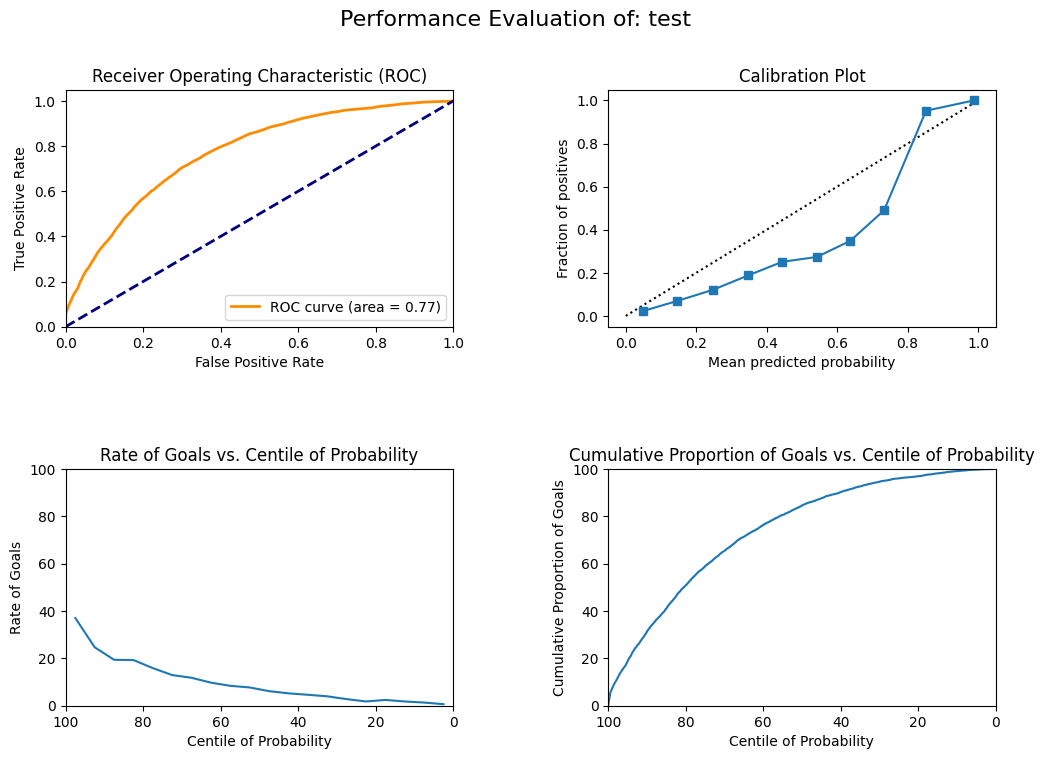

In [31]:
plots(y_val, predictions.reshape(-1), "test")

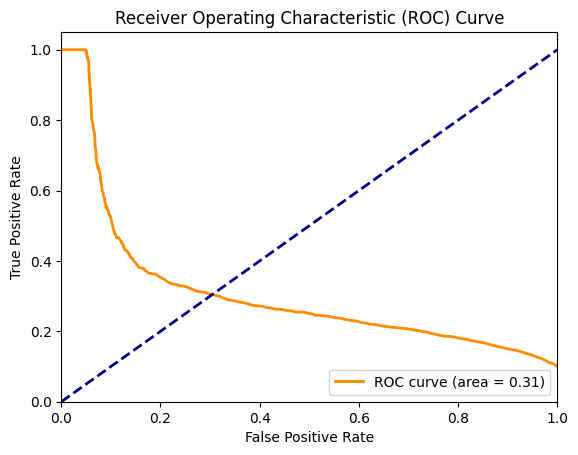

In [180]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(val_labels, predictions)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(val_labels, predictions)
auc_score = auc(recall, precision)

# Plotting ROC curve
plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [181]:
print(model.summary())

Model: "random_forest_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (15):
	Game_id
	Game_time
	Goalie_ratio
	Opp_concedes
	P_diff
	Pe_enc
	Previous_distance
	Rebound_angle
	Shooter_ratio
	Shot_angle
	Shot_distance
	Speed
	Team_goals
	Time_since_powp
	Type_enc

Trained with weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.     "Shot_distance"  0.317370 ################
    2.        "Shot_angle"  0.155764 #####
    3.      "Goalie_ratio"  0.149446 #####
    4.             "Speed"  0.123687 ###
    5.     "Shooter_ratio"  0.108036 ###
    6.         "Game_time"  0.096599 ##
    7.            "Pe_enc"  0.089794 #
    8. "Previous_distance"  0.085934 #
   